In [43]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader, Dataset
import  torchvision.transforms as transforms

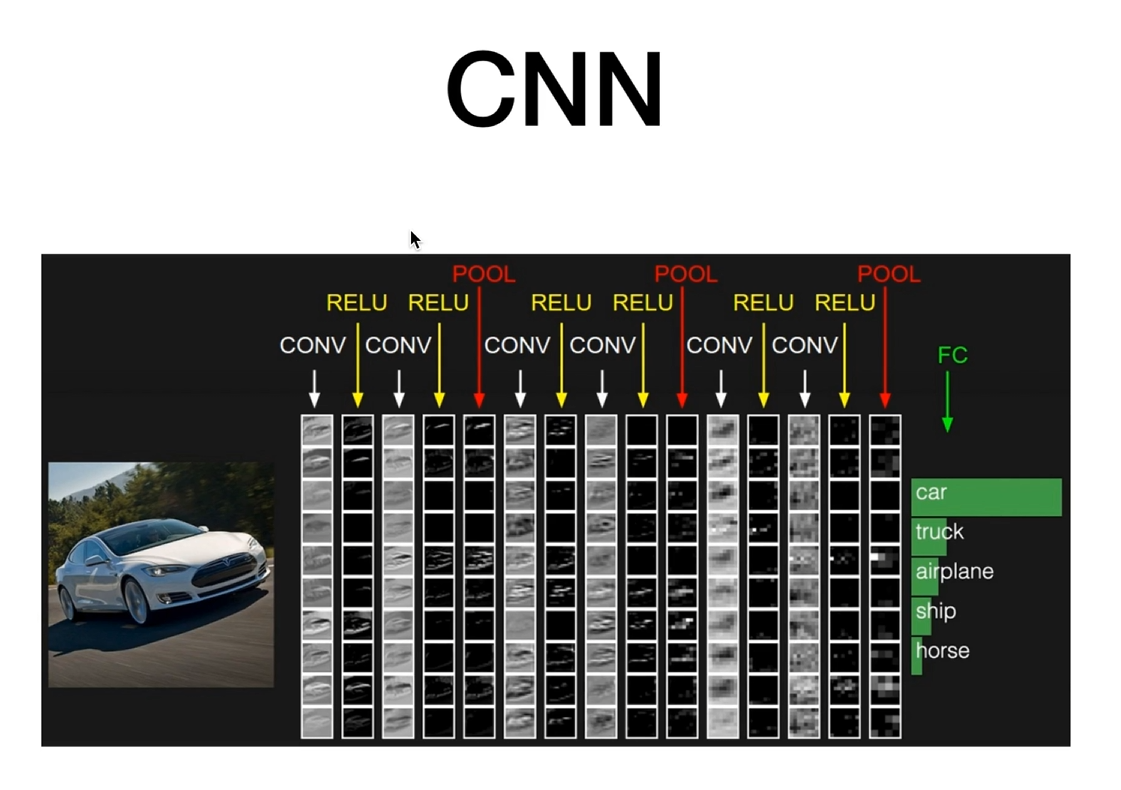

# Architecture of CNN
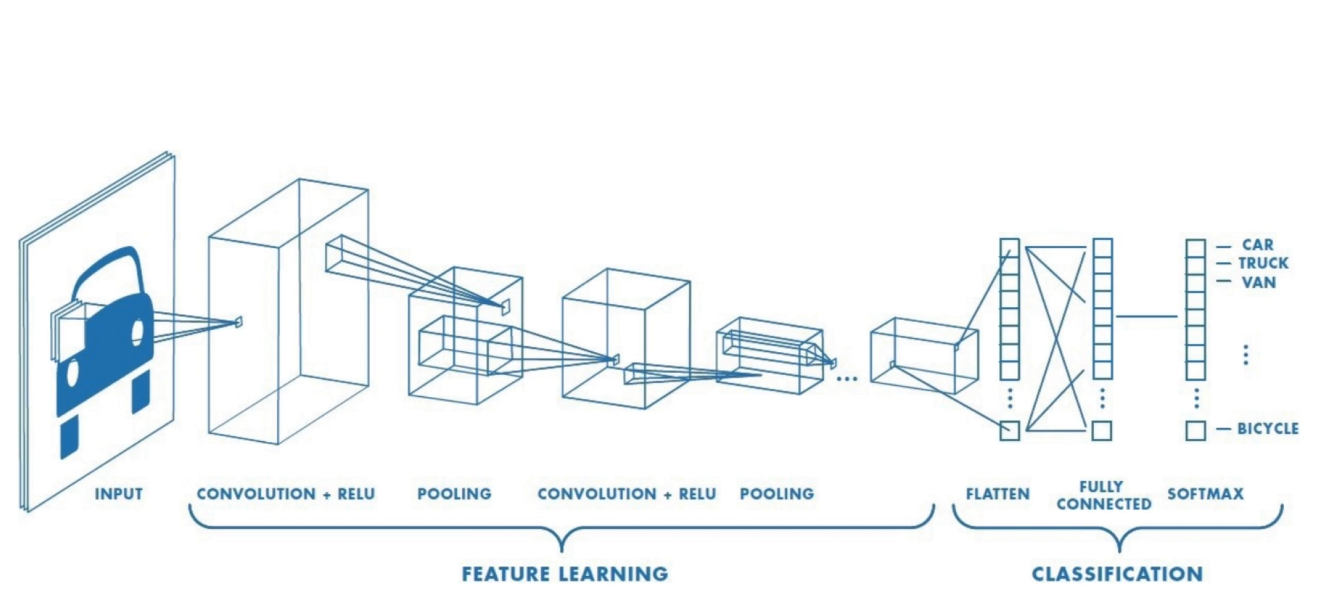

W = input width
F = filter size
2P = 2 * Padding 
S = Stride

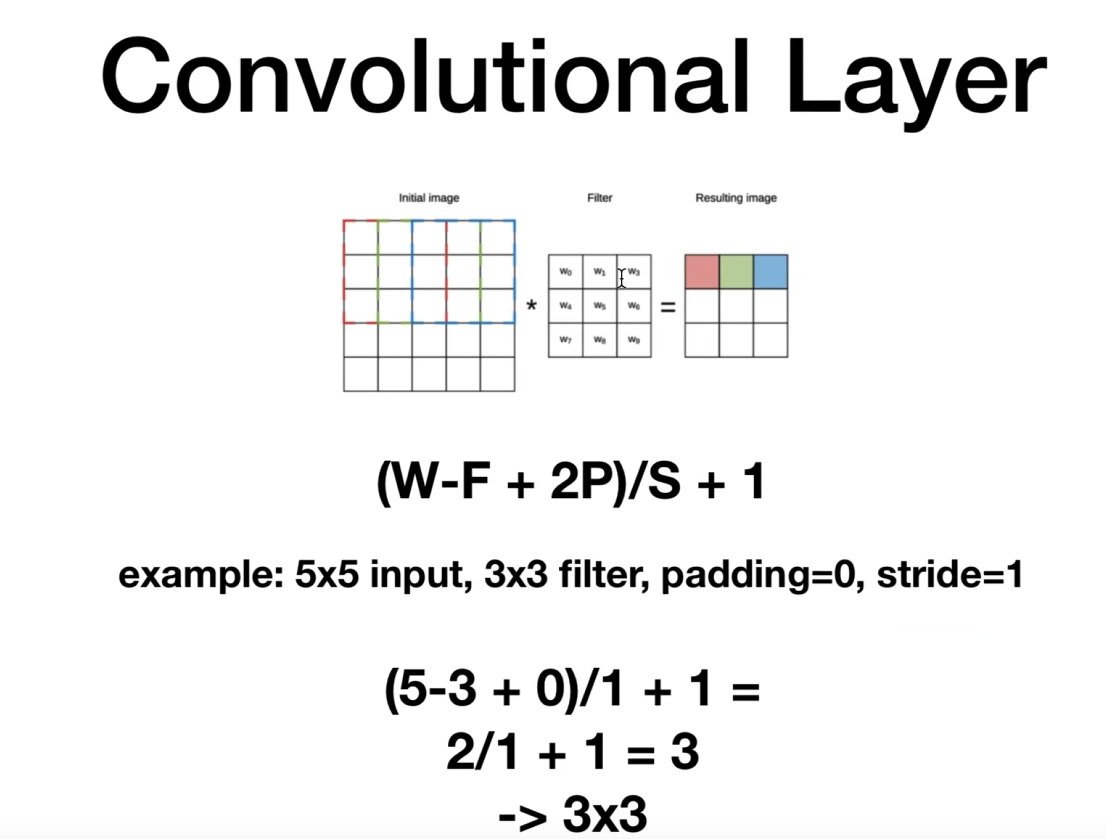

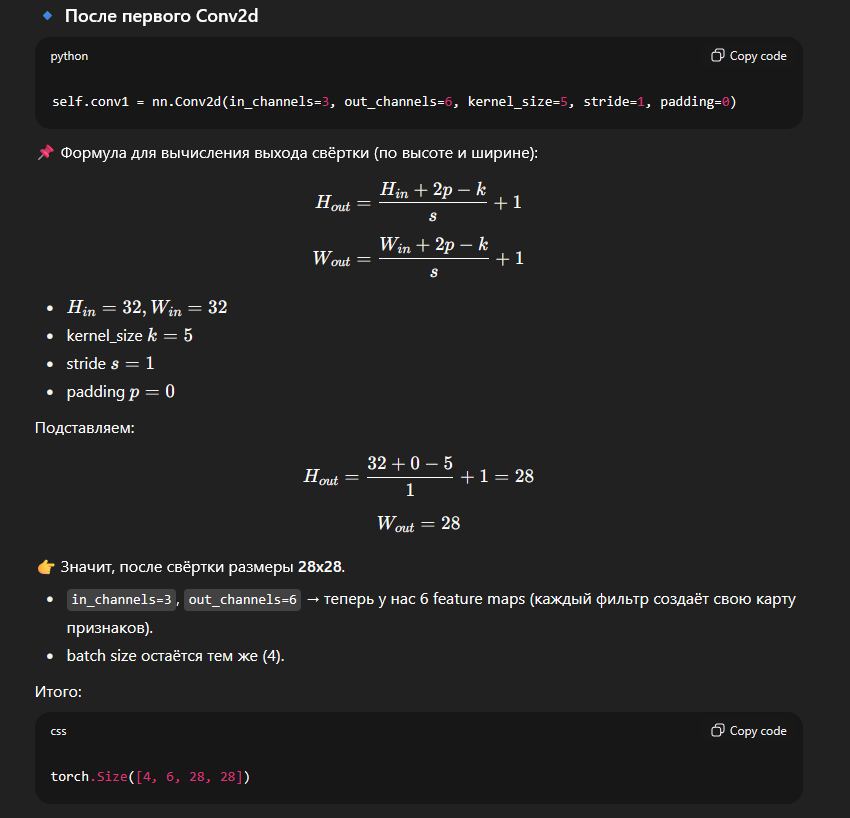

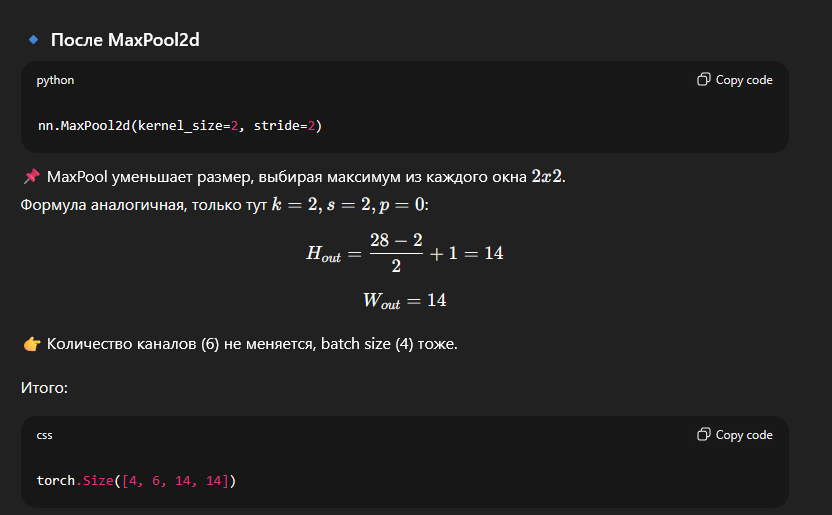

# Device configuration

In [44]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Hyper-params

In [45]:
num_epochs = 4
batch_size = 4
learning_rate = .001

# DataSet and transform
dataset has PILImage images of range [0, 1].
We transform them to Tensors of normalizerd range [-1, 1]

In [46]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((.5, .5, .5), (.5, .5, .5))]    # ???
)

In [47]:
train_dataset = torchvision.datasets.CIFAR10(root='./data_CIFAR10', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data_CIFAR10', train=False, download=False, transform=transform)

In [48]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
tets_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [49]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Implement NeuralNetwork class

In [50]:
class MyConvNN(nn.Module):
    
    def __init__(self):
        super(MyConvNN, self).__init__()
        
        # Convvolved image size = (W - F + 2P) / S + 1
        # image = 32x32
        
        # Convvolved image size = (32 - 5 + 2 * 0) / 1 = 28
        
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)    # (32 - 5 + 2 * 0) / 1 = 28
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, 5)    # output image from first conv_layer = 28x28
        
        self.fc1 = nn.Linear(16*5*5, 120)    # 16*5*5 must be fix, cause we get 16 output layer and picture 5x5, from last conv layer 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        
        # Conv layers 
        
        # conv1 -> relu -> maxpool -> result [n_samples, 6 different feature maps, 28x28 image]
        out = F.relu(self.conv1(x))
        out = self.pool(out)
        
        # conv2 -> relu -> maxpool -> result [n_samples, 16 different feature maps, 5x5 image]
        out = F.relu(self.conv2(out))
        out = self.pool(out)
        # at the end we get [4, 16, 5, 5]
        
        out = out.view(-1, 16*5*5)   # we get flattened tensor
        
        # Linear layers
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out) # no need activation func and softmax or etc
        
        
        return out
        


In [51]:
model = MyConvNN().to(device)

# Loss and optimizer

In [52]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) # learning_rate = .001

In [9]:
len(train_dataloader)

12500

# Training loop

In [53]:
n_total_steps = len(train_dataloader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_dataloader):
        
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)
        
        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 2000 == 0:
            print(f'epoch: {epoch+1}/{num_epochs}, step: {i}/{n_total_steps}, loss: {loss.item():.4f}')
        
        
print('Finish Training')     

epoch: 1/4, step: 1999/12500, loss: 2.2779
epoch: 1/4, step: 3999/12500, loss: 2.3038
epoch: 1/4, step: 5999/12500, loss: 2.3134
epoch: 1/4, step: 7999/12500, loss: 2.2938
epoch: 1/4, step: 9999/12500, loss: 2.2836
epoch: 1/4, step: 11999/12500, loss: 2.2223
epoch: 2/4, step: 1999/12500, loss: 2.1576
epoch: 2/4, step: 3999/12500, loss: 2.0943
epoch: 2/4, step: 5999/12500, loss: 2.1924
epoch: 2/4, step: 7999/12500, loss: 2.3247
epoch: 2/4, step: 9999/12500, loss: 1.8512
epoch: 2/4, step: 11999/12500, loss: 2.2030
epoch: 3/4, step: 1999/12500, loss: 2.3084
epoch: 3/4, step: 3999/12500, loss: 2.4046
epoch: 3/4, step: 5999/12500, loss: 1.4659
epoch: 3/4, step: 7999/12500, loss: 1.6954
epoch: 3/4, step: 9999/12500, loss: 1.5477
epoch: 3/4, step: 11999/12500, loss: 1.4311
epoch: 4/4, step: 1999/12500, loss: 2.1507
epoch: 4/4, step: 3999/12500, loss: 1.4564
epoch: 4/4, step: 5999/12500, loss: 1.7438
epoch: 4/4, step: 7999/12500, loss: 1.4674
epoch: 4/4, step: 9999/12500, loss: 2.2642
epoch: 4

# Evaluate a model

In [54]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    
    for images, labels in tets_dataloader:
        
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value, index)
        
        _, predicted = torch.max(outputs, dim=1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1
    
    acc = 100.0 * n_class_correct[i] / n_class_samples[i]
    print(f'Accuracy of NN: {acc}%')
    
    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc}%')
    
print('Done')

Accuracy of NN: 33.2%
Accuracy of plane: 55.2%
Accuracy of car: 52.1%
Accuracy of bird: 34.7%
Accuracy of cat: 33.2%
Accuracy of deer: 22.6%
Accuracy of dog: 50.3%
Accuracy of frog: 56.2%
Accuracy of horse: 40.8%
Accuracy of ship: 42.0%
Accuracy of truck: 50.1%
Done


The results it's bad, cause we has a lot amount of `num_epochs` (need to try more)  